# Analyzing COVID-19 Data in California

In [1]:
#import all libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## 1) Business Understanding

Currently living in San Francisco, I was wondering what is the safest county to be at when the lockdown will be eased. This is what pushed me to explore the dataset of COVID-19 by counties and try to answer these questions:

1. What are the counties that should ease their lockdown policy
2. Which county or counties should not re-open?




## 2) Data Understanding

#### Gather Data

In [2]:
#dataset for the analysis
df = pd.read_csv('Downloads/us-counties.csv', index_col =0 )

In [3]:
df.head()

,county,state,fips,cases,deaths
date,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0
2020-01-22,Snohomish,Washington,53061.0,1,0
2020-01-23,Snohomish,Washington,53061.0,1,0
2020-01-24,Cook,Illinois,17031.0,1,0
2020-01-24,Snohomish,Washington,53061.0,1,0


#### Checking for missing values

In [4]:
df.describe()

,fips,cases,deaths
count,134025.000000,135570.000000,135570.000000
mean,29929.727730,253.072590,13.374847
std,15402.442915,2820.767159,255.194342
min,1001.000000,0.000000,0.000000
25%,18047.000000,3.000000,0.000000
50%,29029.000000,12.000000,0.000000
75%,45023.000000,56.000000,2.000000
max,56043.000000,190546.000000,19563.000000


In [5]:
df_group_by_state = df.groupby(by=['date','county']).sum()

In [6]:
df_group_by_state.head()

fips  cases  deaths
date       county                           
2020-01-21 Snohomish  53061.0      1       0
2020-01-22 Snohomish  53061.0      1       0
2020-01-23 Snohomish  53061.0      1       0
2020-01-24 Cook       17031.0      1       0
           Snohomish  53061.0      1       0

## 3) Data Preparation

Let's first take a look at the number of cases and death accross all counties.

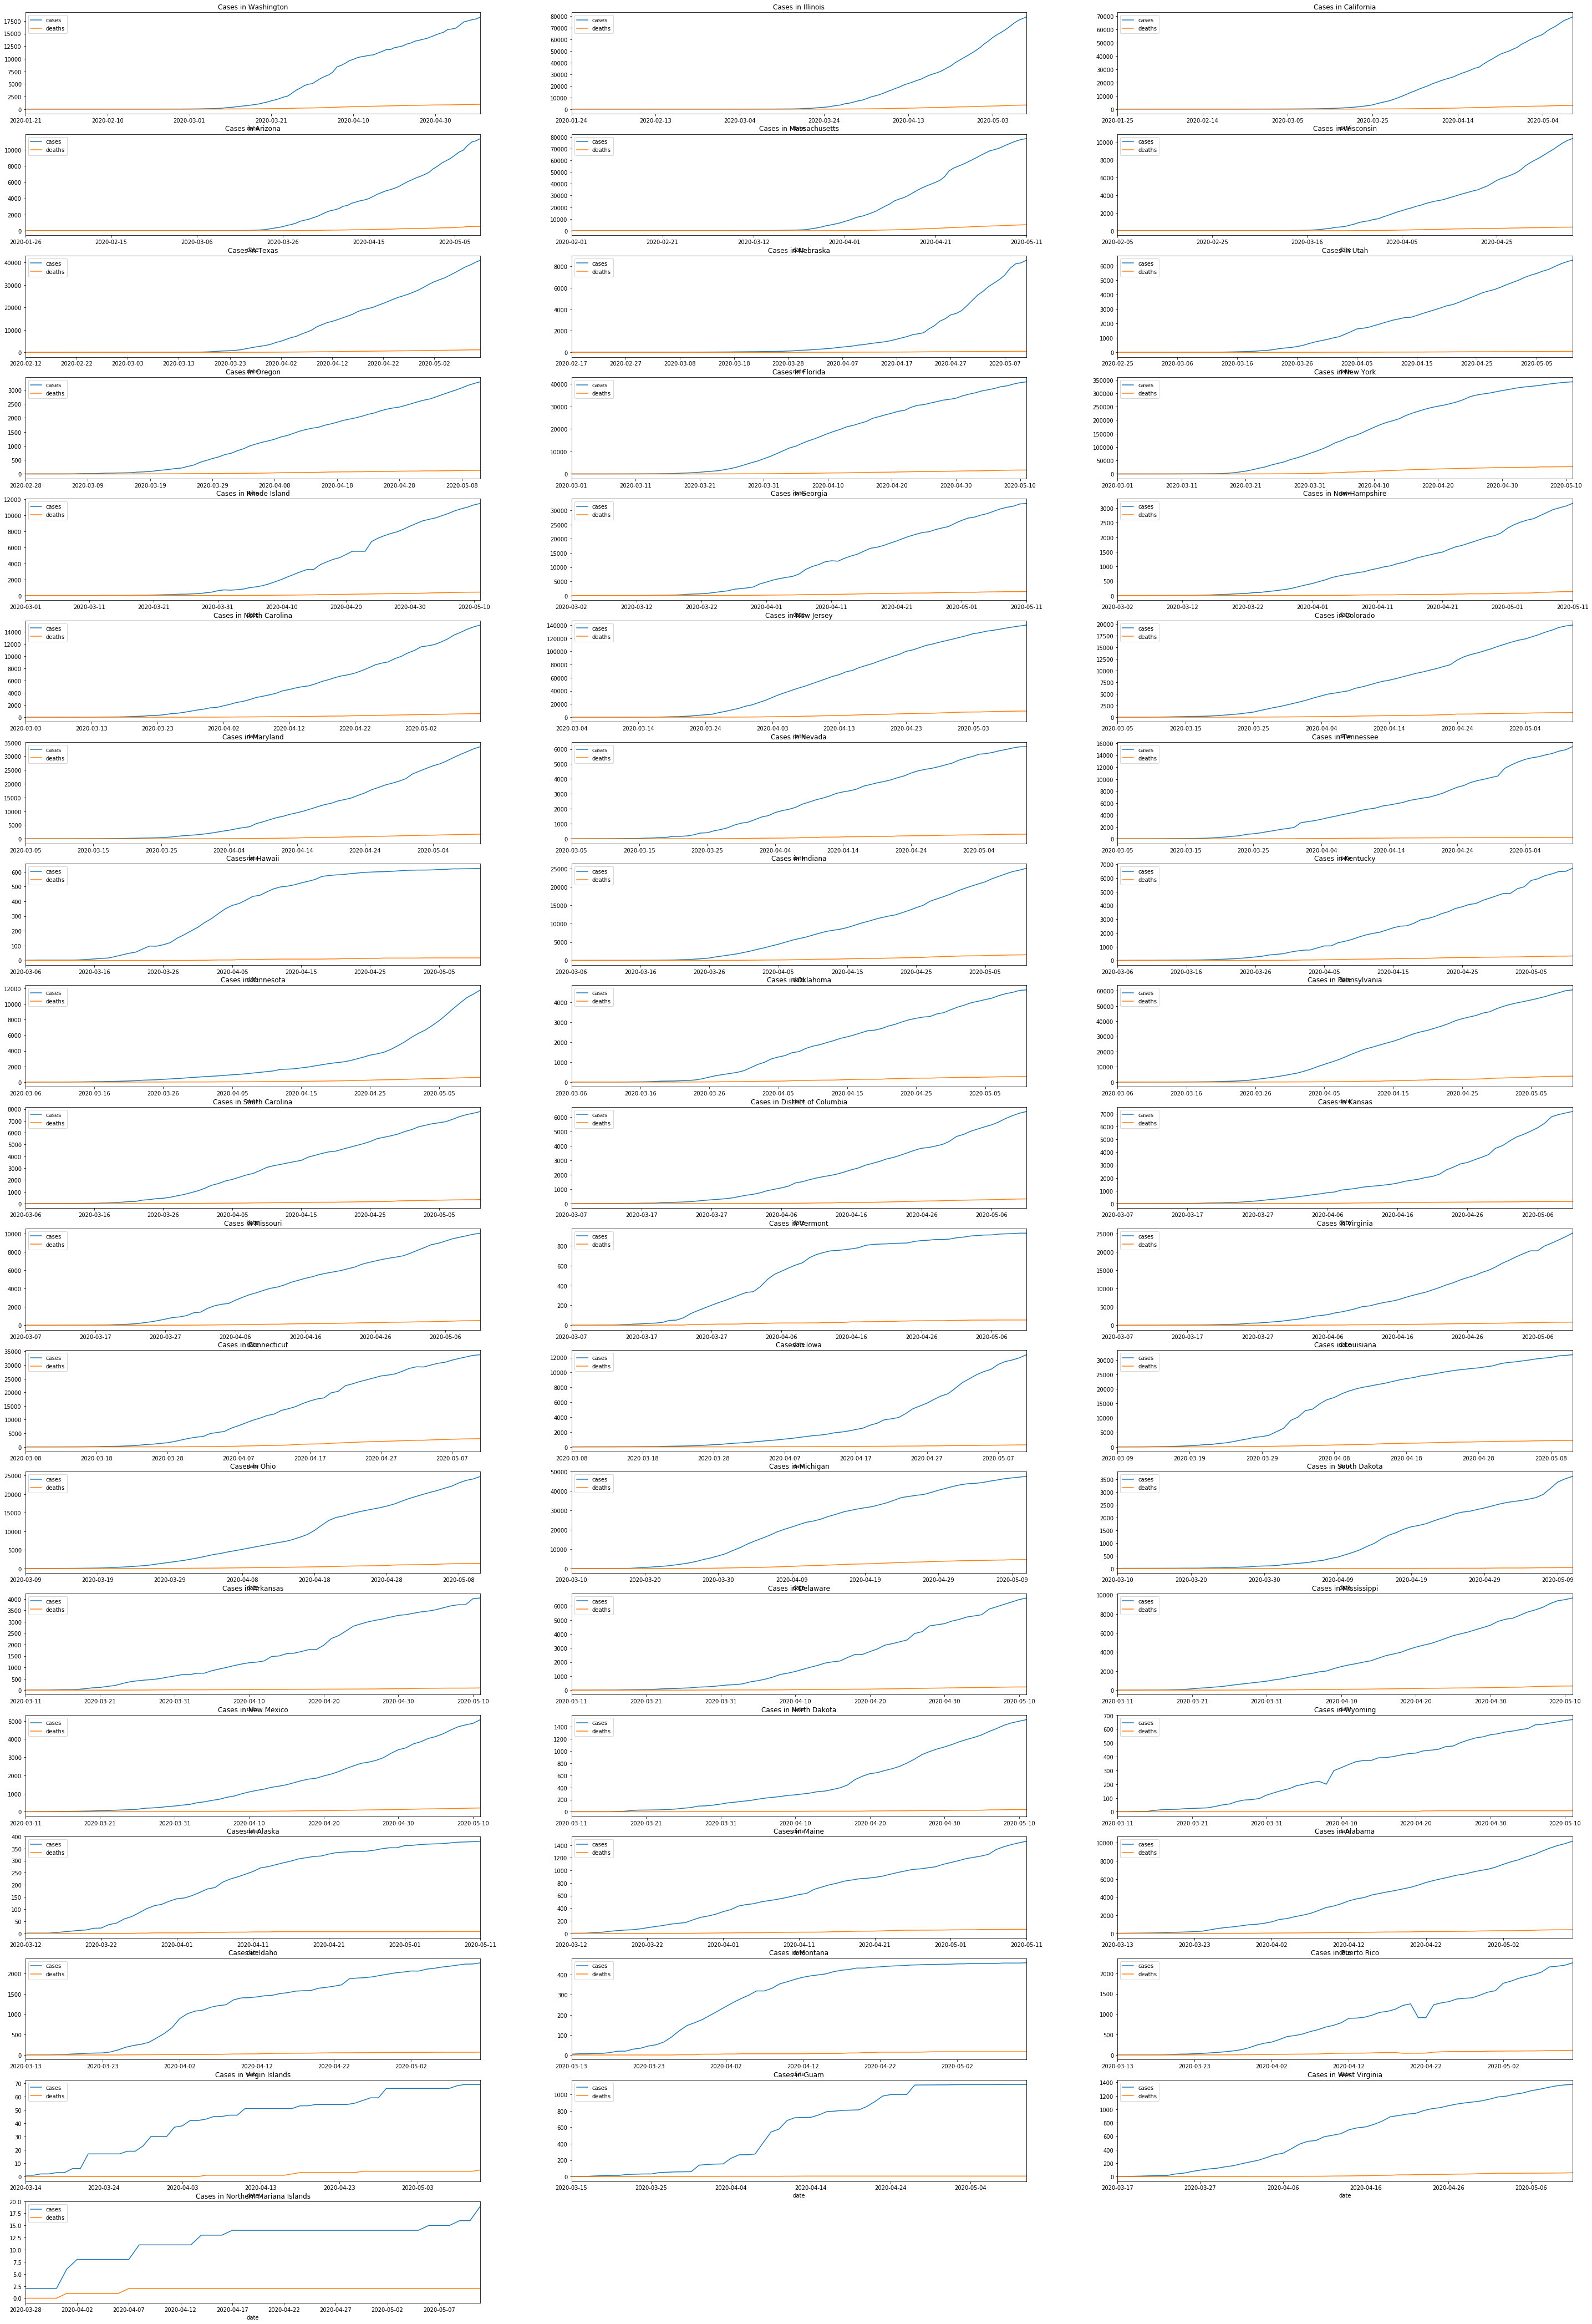

In [7]:
fig = plt.figure()

for i, state in enumerate(df.state.unique()):
    ax = fig.add_subplot(20,3,i+1)
    df[df['state']==state][['cases','deaths']].groupby(by='date').sum().plot(figsize=(50,80), ax=ax)
    plt.title('Cases in '+state)


### Clean the data 

This analysis will be based only on California. Let's just dig into California

In [8]:
california = df[df['state']=='California']

In [9]:
california.head(3)

,county,state,fips,cases,deaths
date,,,,,
2020-01-25,Orange,California,6059.0,1,0
2020-01-26,Los Angeles,California,6037.0,1,0
2020-01-26,Orange,California,6059.0,1,0


In [10]:
california.describe()

,fips,cases,deaths
count,3319.000000,3336.000000,3336.000000
mean,6058.892136,476.589628,17.558453
std,32.558740,2132.444962,98.461397
min,6001.000000,0.000000,0.000000
25%,6031.000000,4.000000,0.000000
50%,6061.000000,31.000000,1.000000
75%,6085.000000,211.250000,5.000000
max,6115.000000,32258.000000,1569.000000


There seems to be no data missing except for FIPS (federal code for testing) that won't be used in our analysis. We will drop this column.

In [11]:
agg = california.groupby(by='county').max().drop('fips', axis=1).sort_values(by='cases', ascending=False)
agg.head()

,state,cases,deaths
county,,,
Los Angeles,California,32258,1569
Riverside,California,5189,217
San Diego,California,5128,194
Orange,California,3627,76
San Bernardino,California,3015,121


##### Adding a new column to the dataset

To be able to see how deadly is the virus I will take a look at the number of death per case.

In [12]:
agg['cases_per_death'] = agg['cases']/agg['deaths']

## 4) Answer the questions

### Question 1
#### What are the counties that should ease their lockdown policy

Digging into the data, the first step would be to check the number of cases and death in each county. In order to make the analysis relevant, we will just dig into the top 15 in terms of cases and death in California.

First step is to create a barplot or barchart that will sort the counties in California based on their number of cases. We can also normalize these values based on the square footage. Each county has a different square footage and if the surface of the county is bigger, the number of cases will be as well. Comparing apples to apples here.

Let's start with absolute number first before normalizing them based on the population of the county.

In [13]:
import seaborn as sns 

In [14]:
def barhchart(data=agg):
    sns.set(style="whitegrid")

    plt.figure(figsize=(30,20))
    b = sns.barplot(y=agg.iloc[:15].index, x= agg.iloc[:15]['cases'], color='b',)
    plt.xticks(size = 30)
    plt.yticks(size = 30)

    plt.ylabel('')
    plt.xlabel('')

    plt.tight_layout()

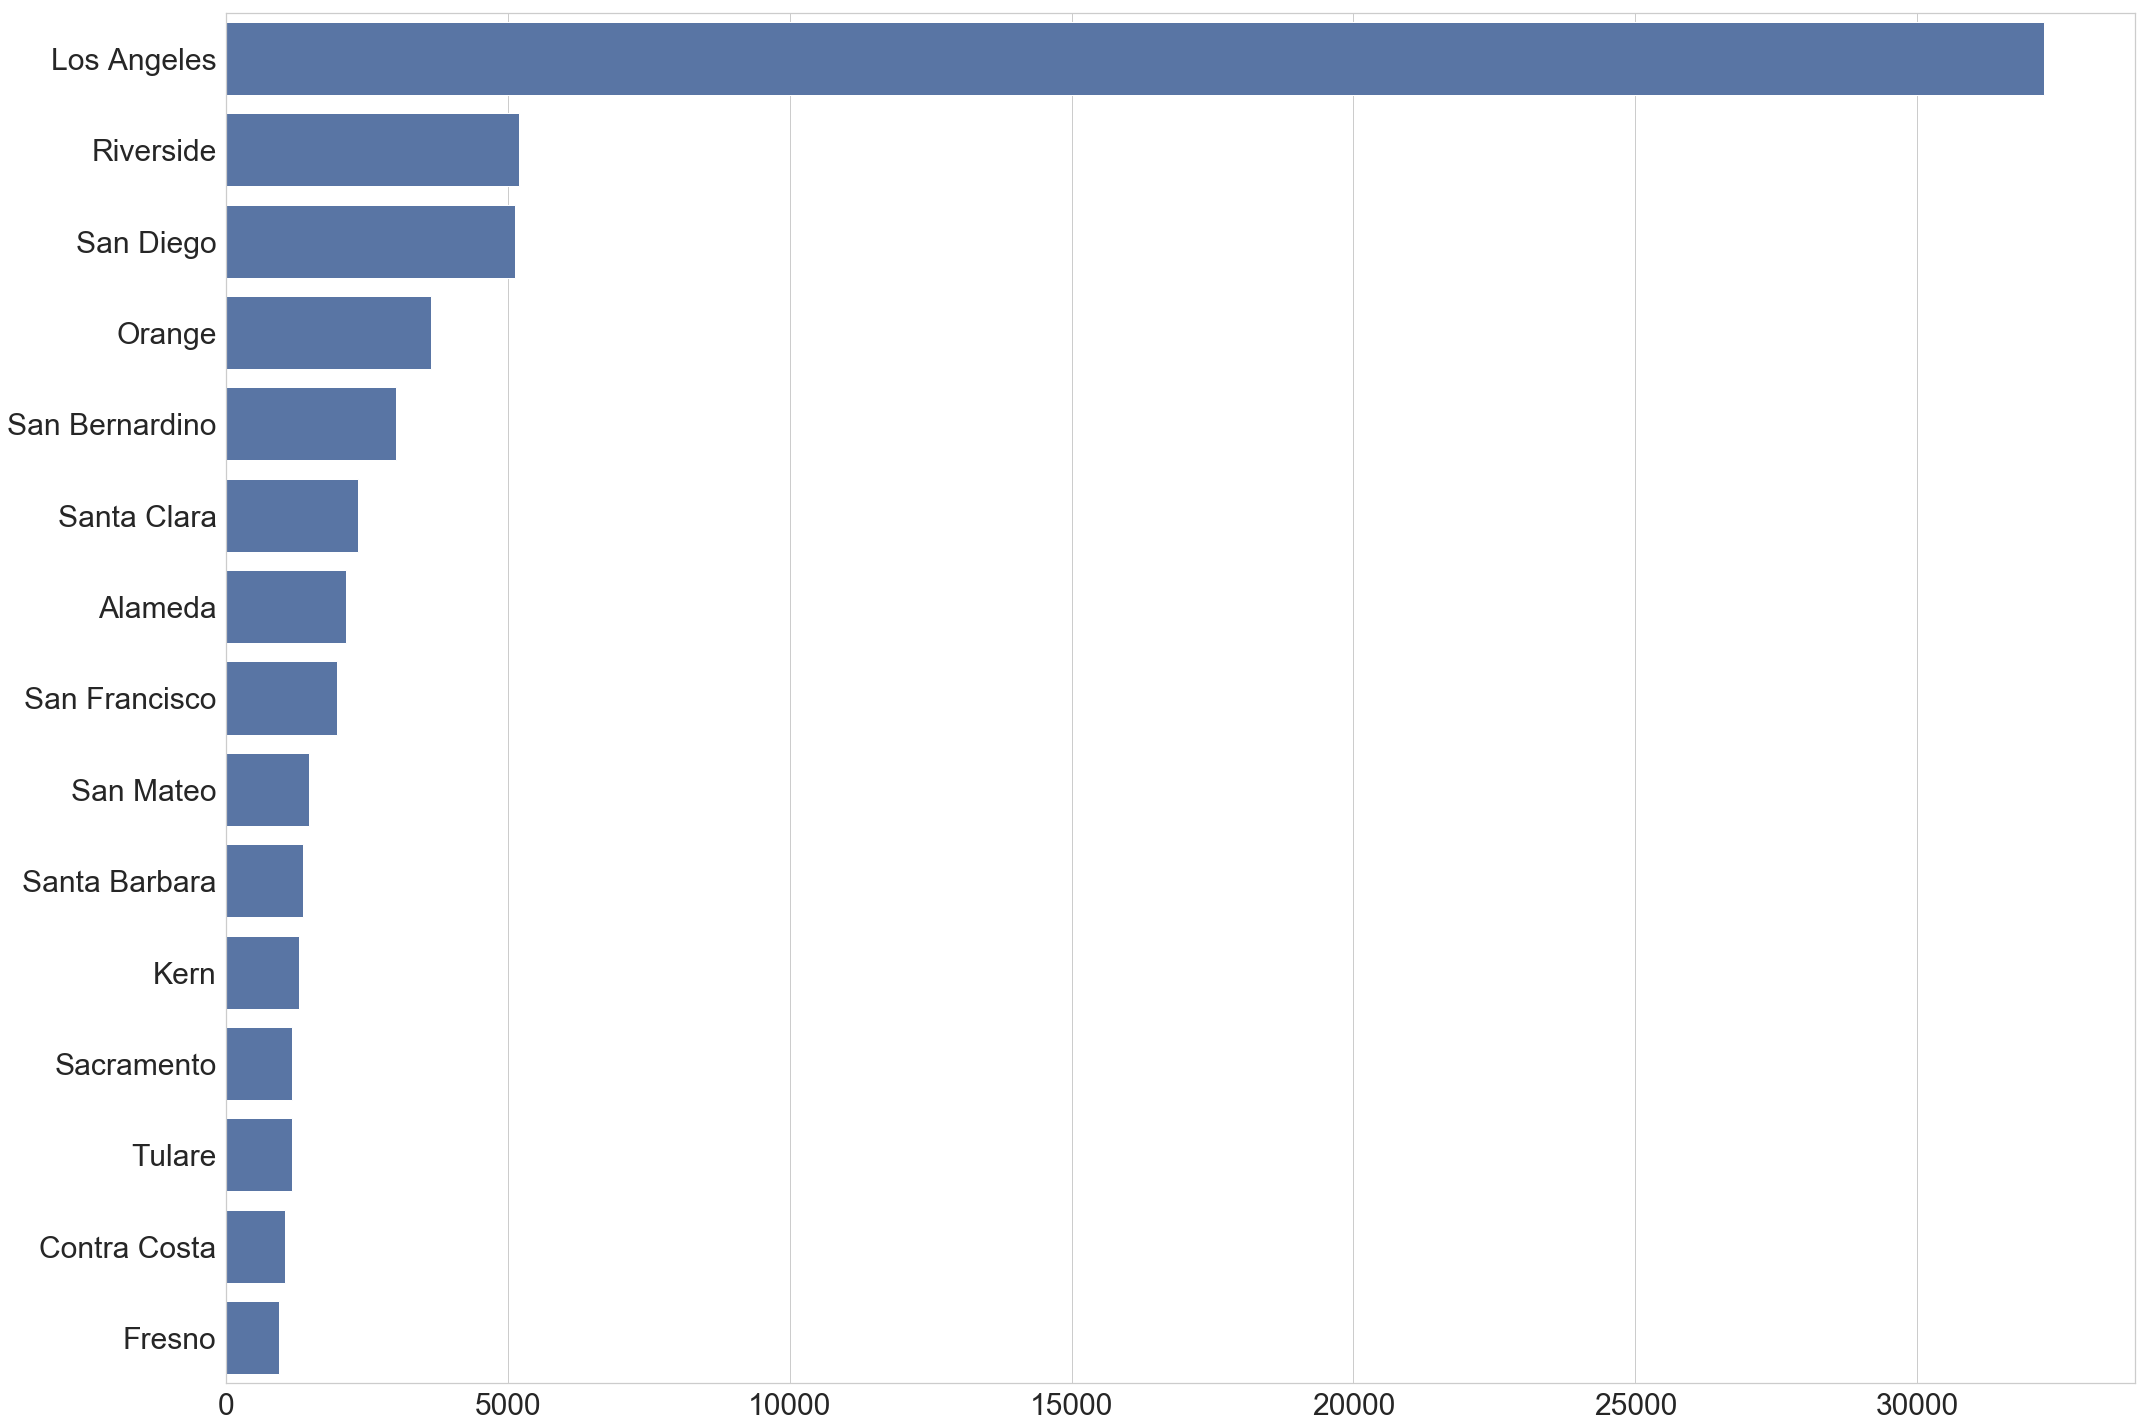

In [15]:
barhchart()

Los Angeles County has the highest number of cases in California, with 32,258 cases as of the 11th of May. It’s followed by Riverside and San Diego. San Francisco is at the 8th position with 1957 cases.

Los Angeles is leading by a lot. But it is also not fair to compare this county to San Francisco that accounts for around 10 times fewer people and thus have a higher chance to have fewer cases. In order to make the comparison fairer between counties, I will be looking at the percentage of the population that is infected rather than the absolute number.

In [19]:
#The data here was imported from Census 2020. In case anyone wants to change the data (to correct population numbers)
#I'll create a dictionary for that

population = {
        'Los Angeles': 10105518,
        'Riverside': 2450758,
        'San Diego': 3343364,
        'Orange': 3185968,
        'San Bernardino': 2171603,
        'Santa Clara': 1937570,
        'Alameda': 1666753,
        'San Francisco': 883305,
        'San Mateo': 769545,
        'Santa Barbara': 446527,
        'Kern': 896764,
        'Sacramento': 1540975,
        'Tulare': 465861,
        'Contra Costa': 1150215,
        'Fresno': 994400
}

In [21]:
population_bis = {'counties': list(population.keys()), 'population': list(population.values())}
population_df = pd.DataFrame(population_bis).set_index('counties')

In [25]:
#let's just look at the top 15 county with highest cases
top_15 = agg.iloc[:15]
top_15 = pd.concat([top_15, population_df], axis=1)
top_15.drop('state', axis=1) #dropping state as we are just digging into california

#creating a new column called pct_infected that will represents the number of cases in the county divided by the 
#population of the county
top_15['pct_infected'] = top_15['cases']/top_15['population']

In [26]:
def barchart(df, x, y):
    sns.set(style="whitegrid")

    plt.figure(figsize=(30,20))
    b = sns.barplot(y=y, x= x, data=df , color='b')
    plt.xticks(size = 30)
    plt.yticks(size = 30)

    plt.ylabel('')
    plt.xlabel('')

    plt.tight_layout()

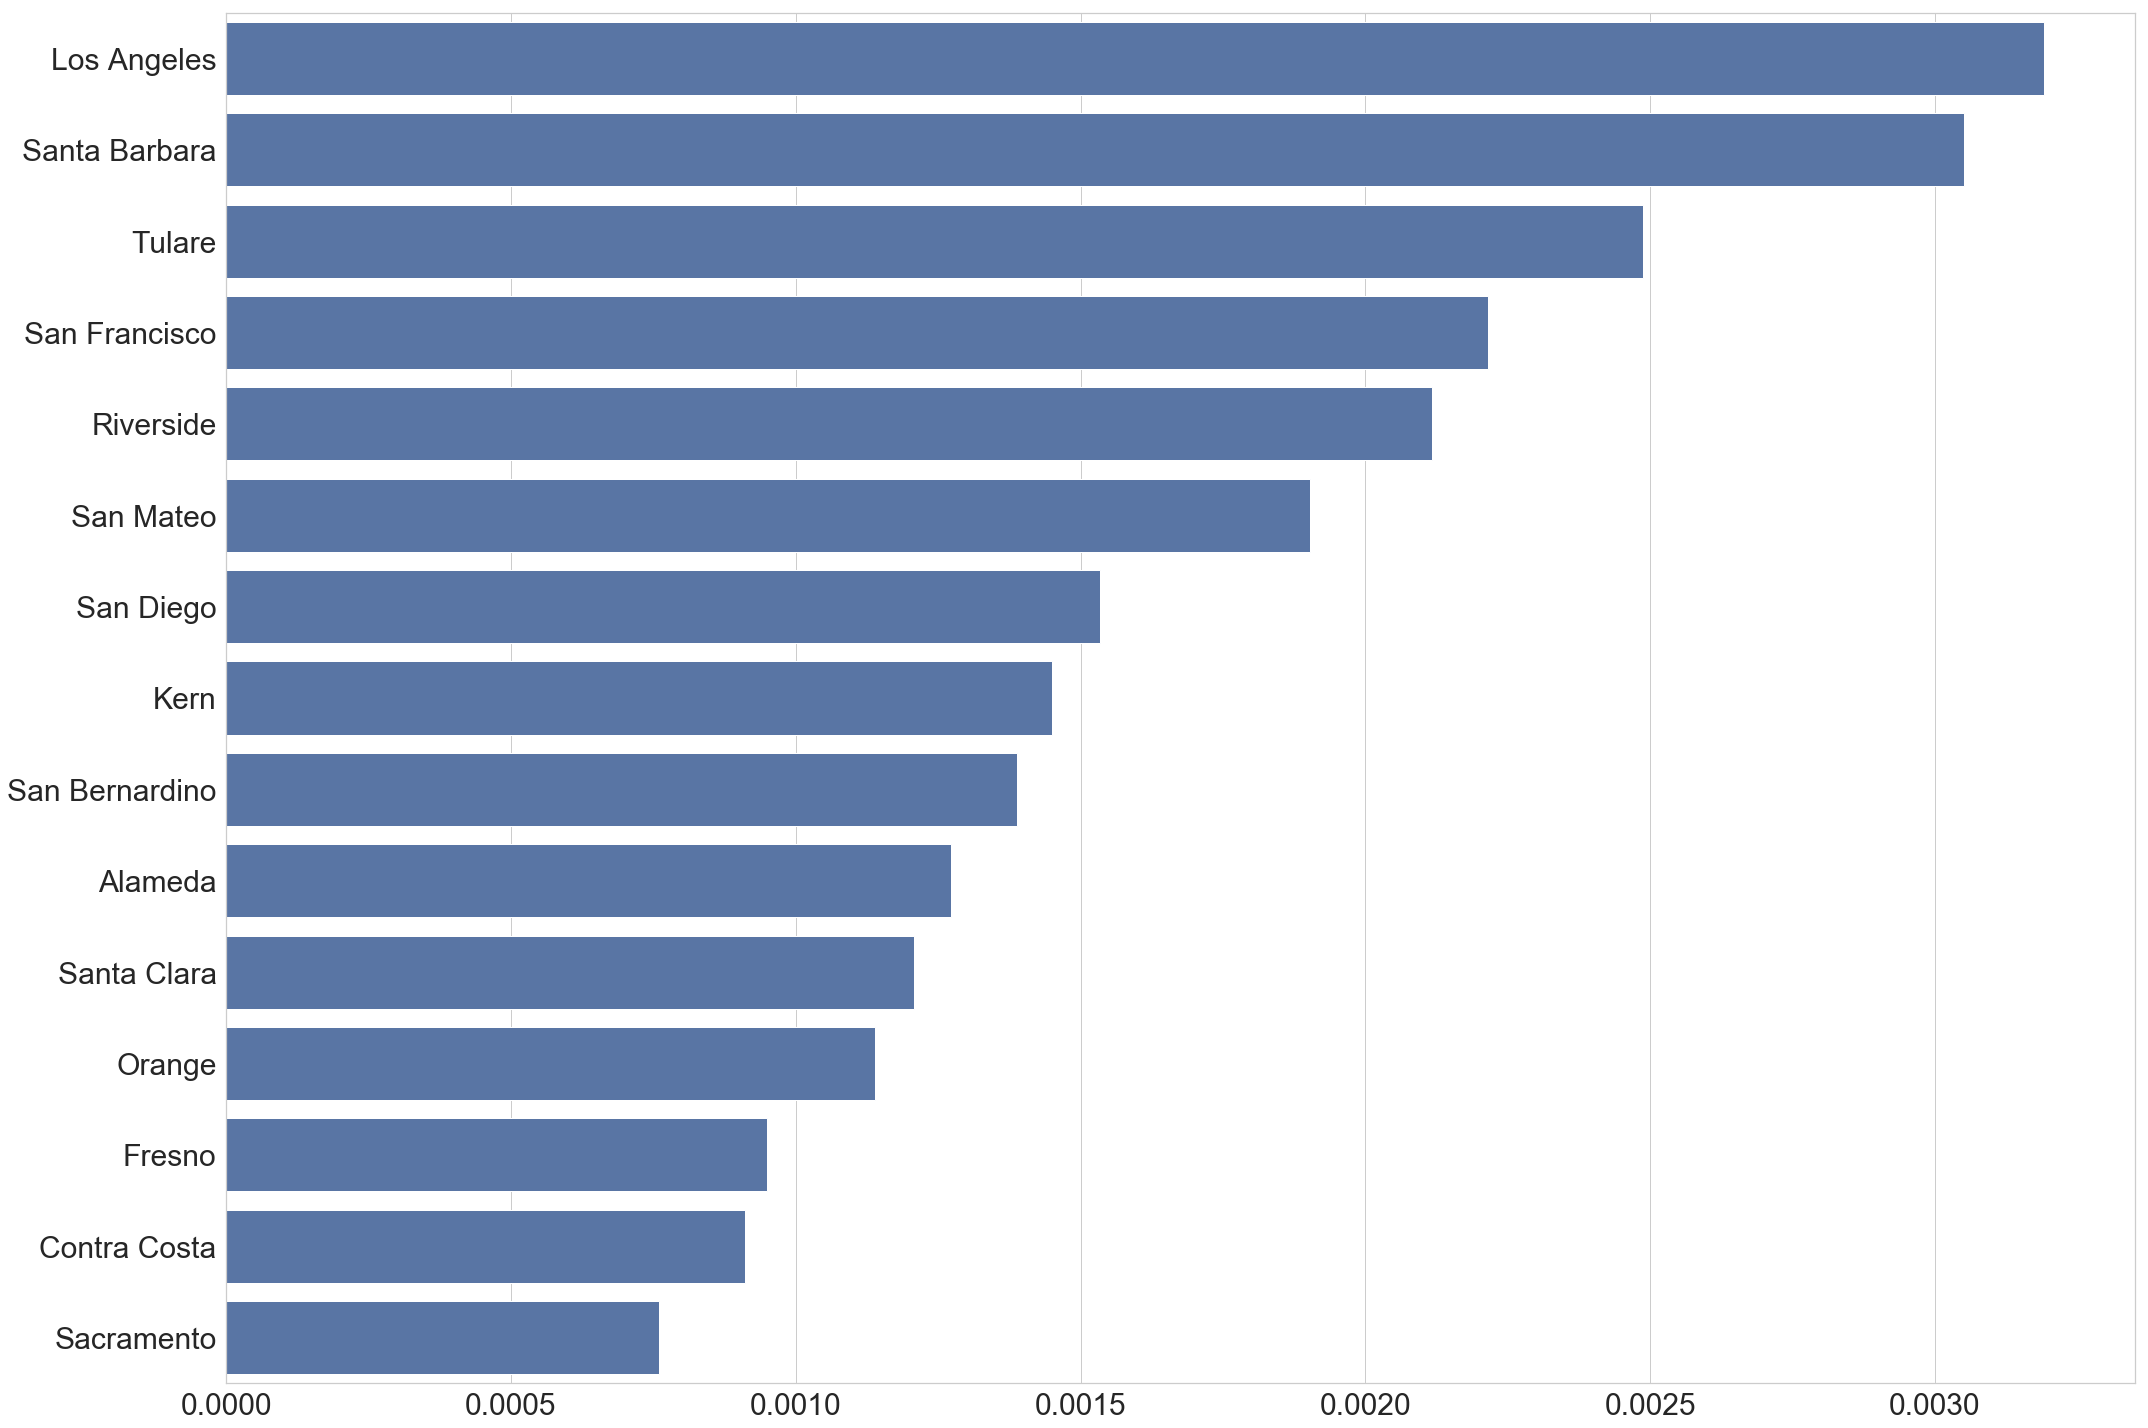

In [27]:
barchart(top_15.reset_index().sort_values(by='pct_infected', ascending=False), y='index', x='pct_infected')

Infection rate is telling us a different story than looking at the absolute number of cases. A county with a high infection rate could translate to a fast propagation of the virus and would need a more conservative approach.

*Sacramento has the lower infection rate*

In addition to that, I will take a look at the number of daily new cases by the county during this period. That will give me more certainty on whether or not a county should re-open or not. In order to avoid the daily spikes (that could be due to low availability of testing), I decided to use a 7-day moving average to have a directionally correct way to look into the data.

The data on the california dataset are based on cumulative numbers. We would need to determine the number of new cases

In [28]:
california['lagged_cases'] = california.groupby('county')['cases'].shift(1)

#I am filling null values and replacing them by 0. As the shift function will give a null value to the first value of the dataset
california['lagged_cases'] = california['lagged_cases'].fillna(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
#After doing this change, I will substract the number of cumulative cases to the lagged cases to get the number of new cases

In [30]:
california['lagged_cases']=california['cases'] - california['lagged_cases']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
#let's now take a look at the dataset for the Los Angeles county
california[california['county']=='Los Angeles'].head(4)

,county,state,fips,cases,deaths,lagged_cases
date,,,,,,
2020-01-26,Los Angeles,California,6037.0,1,0,1.0
2020-01-27,Los Angeles,California,6037.0,1,0,0.0
2020-01-28,Los Angeles,California,6037.0,1,0,0.0
2020-01-29,Los Angeles,California,6037.0,1,0,0.0


In [32]:
#will rename the lagged cases to new cases to avoid any misinterpretation
california.rename(columns={"lagged_cases": "new_cases"}, inplace =True)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [33]:
california.head()

,county,state,fips,cases,deaths,new_cases
date,,,,,,
2020-01-25,Orange,California,6059.0,1,0,1.0
2020-01-26,Los Angeles,California,6037.0,1,0,1.0
2020-01-26,Orange,California,6059.0,1,0,0.0
2020-01-27,Los Angeles,California,6037.0,1,0,0.0
2020-01-27,Orange,California,6059.0,1,0,0.0


As Sacramento had the lowest infection rate, I wanted first to take a look at the progression of the new cases in this county

In [37]:
sacramento = california[california['county']=='Sacramento']

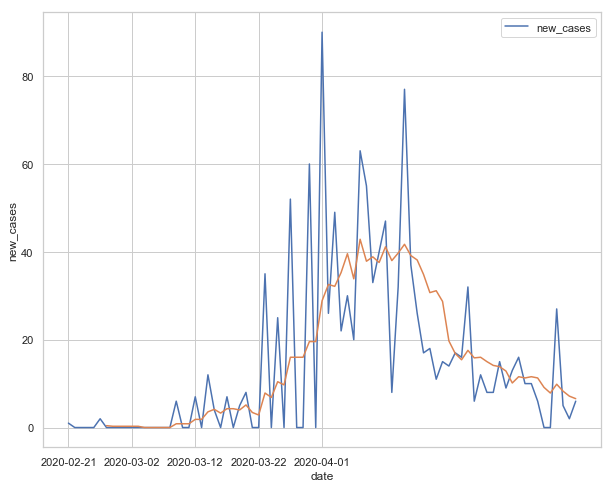

In [39]:
fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(1,1,1)

plt.plot(sacramento.index ,sacramento['new_cases'])
b = sns.lineplot(x=sacramento.index, y=sacramento['new_cases'].rolling(window=7).mean(), ax=ax2)
b.set_xticks(ax.get_xticks()[::2]) #try to space out dates to avoid overlapping
plt.show()

The reason I am using a 7d rolling window is too smoth the data in order to see how the number of new cases is evolving overtime. 

As we can see here, the number of new cases is declining significantly in this county. 

#### Conclusion of question 1 

Sacrament with its low infection rate and significant decrease in new cases is the safest county to re-open.


#### Visualize

In [71]:
california['ma_new_case'] = california.groupby('county')['new_cases'].transform(lambda x: x.rolling(7).mean())
california['ma_new_case']= california['ma_new_case'].fillna(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Question 2
#### Which county or counties should not re-open?

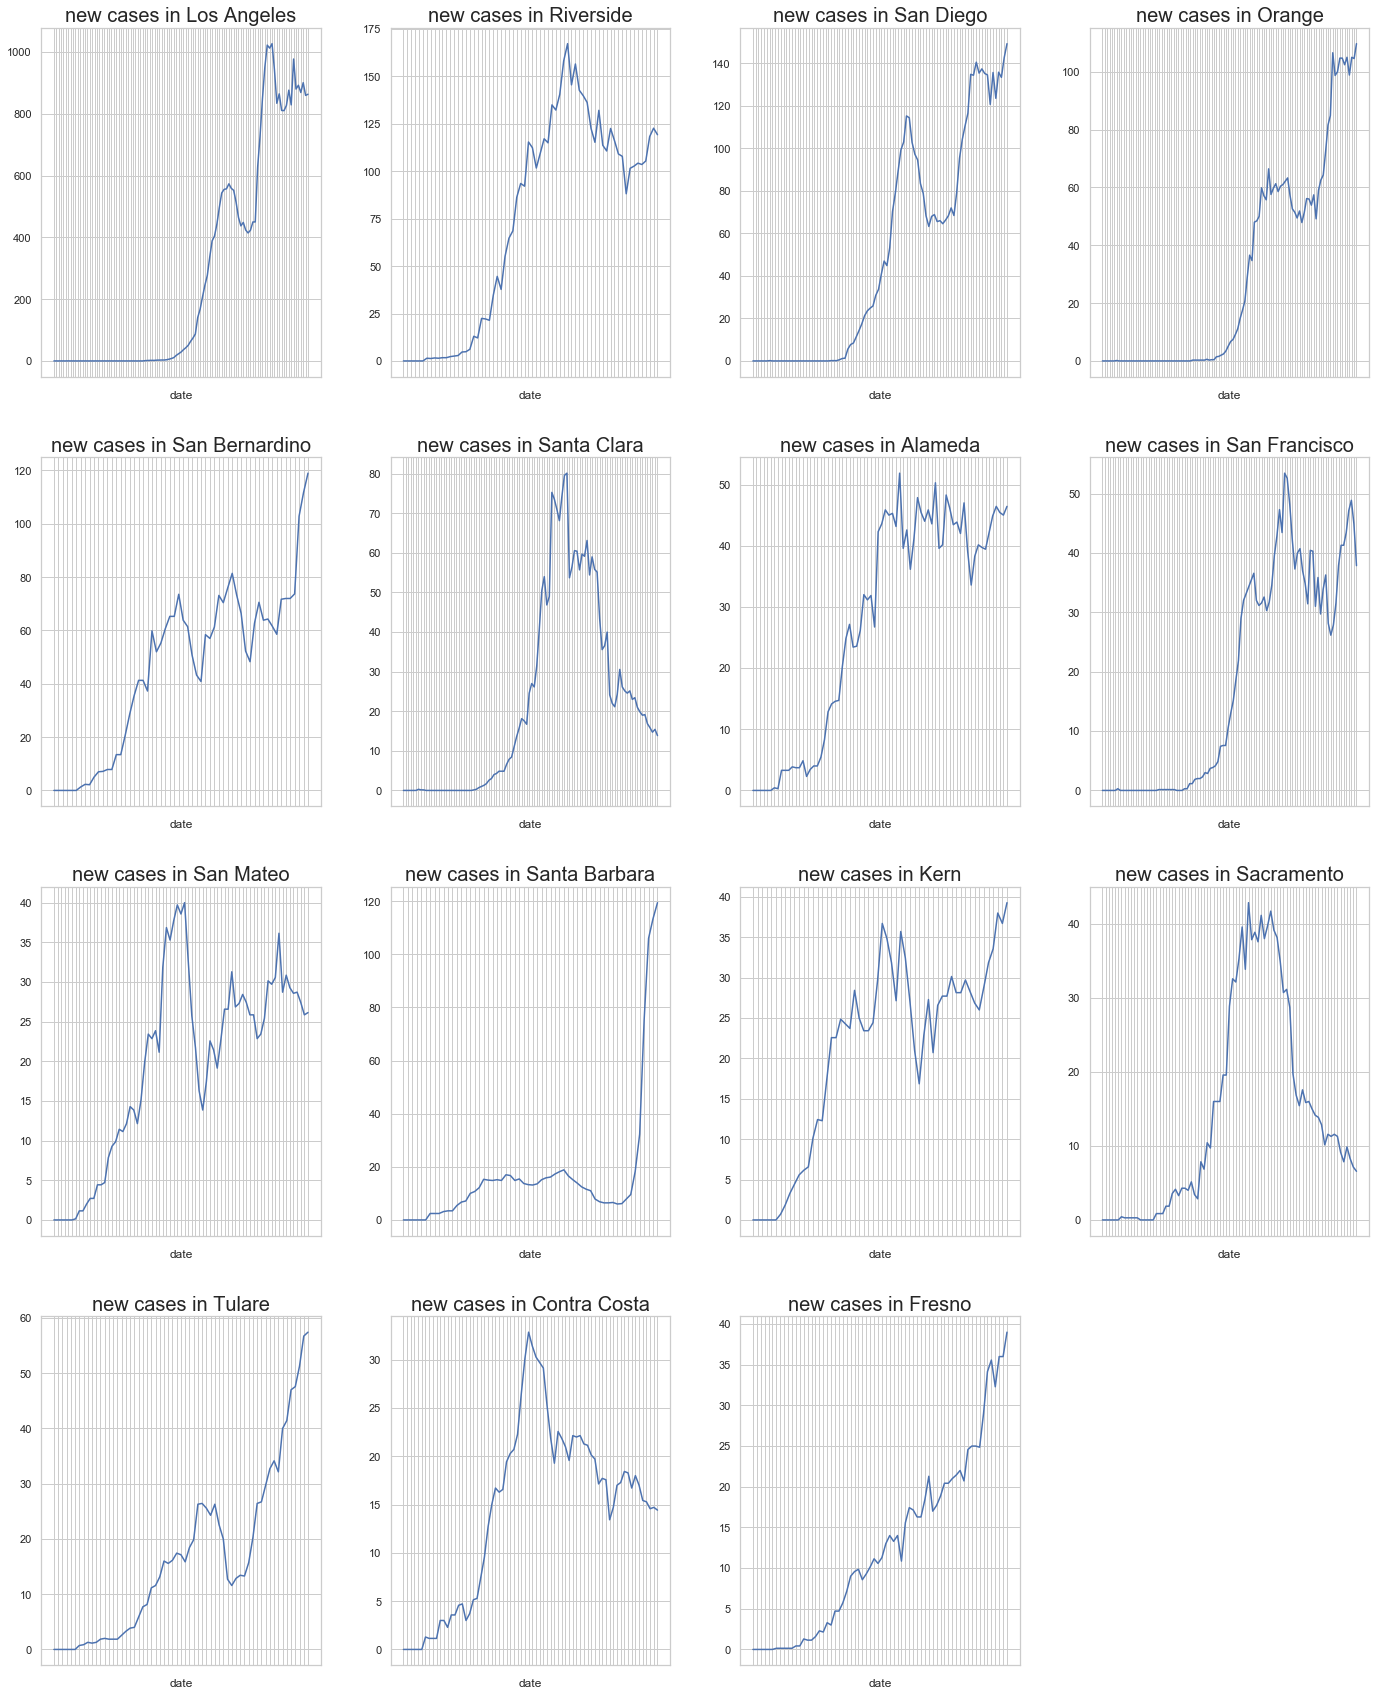

In [70]:
fig1 = plt.figure(figsize=(20,30))


for i,county in enumerate(agg.index[:15]):
    ax1 = fig1.add_subplot(5,4,i+1)
#     sns.lineplot(x='date', y= 'new_cases', data= temp[temp['county']== county].reset_index(), ax=ax1)
    sns.lineplot(x='date', y= 'ma_new_case', data= california[california['county']== county].reset_index(), ax=ax1)
    ax1.set_xticklabels([])
    plt.ylabel('')
    
    plt.title('new cases in '+county, fontdict = {'fontsize' : 20})
    plt.tight_layout(pad=3)

#### Conclusion of question 2 

The county that stands out is Santa Barbara, with a really significant spike in new cases and a historical high infection rate. Re-opening this state will cause the number of new cases to keep rising. For this reason, Santa Barbara should not ease its lockdown policy. 

**Santa Barbara and Los Angeles should not ease its lockdown policy.**